## Install

In [0]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
from torch.nn import functional as thf
import torchvision as tv

## Config

In [0]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Using {device}')

image_shape = (1, 28, 28)
latent_size = 128
hidden_size = 400
num_epochs = 30
batch_size = 128
learning_rate = 0.001


Using cuda


## MNIST Dataset

In [0]:
def create_loader(dataset, shuffle=True):
  return th.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=shuffle)

train_ds = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=True, transform=tv.transforms.ToTensor(),
    download=True)

test_ds = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=False, transform=tv.transforms.ToTensor(),
    download=True)

train_loader = create_loader(train_ds)
test_loader = create_loader(test_ds, shuffle=False)

In [0]:
# Split dataset by class and create loader for each.
def split_by_class(dataset, labels):
  ds_by_class = []
  for i in range(10):
    idx = np.squeeze(np.where(labels == i))
    ds = th.utils.data.dataset.Subset(dataset, idx)
    ds_by_class.append(ds)
  return ds_by_class

train_ds_by_class = split_by_class(train_ds, train_ds.train_labels)
train_loader_by_class = [create_loader(ds) for ds in train_ds_by_class]

test_ds_by_class = split_by_class(test_ds, test_ds.test_labels)
test_loader_by_class = [create_loader(ds, shuffle=False) for ds in test_ds_by_class]

print([len(ds) for ds in train_ds_by_class])
print([len(ds) for ds in test_ds_by_class])

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


In [0]:
for x, y in train_loader_by_class[0]:
  print(x.shape, y.shape)
  break

torch.Size([128, 1, 28, 28]) torch.Size([128])


## Model

In [0]:
class VAE(nn.Module):
  def __init__(self, h_dim, z_dim):
    super(VAE, self).__init__()
    self.enc_h = nn.Sequential(
        nn.Conv2d(1, 8, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        nn.Conv2d(8, 16, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.Conv2d(16, 32, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        nn.Conv2d(32, 64, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.Conv2d(64, 128, 4),
        nn.LeakyReLU(),
    )
    h_dim = 128
    image_size = int(np.prod(image_shape))
    self.enc_mu = nn.Linear(h_dim, z_dim)
    self.enc_logvar = nn.Linear(h_dim, z_dim)
    self.dec_h = nn.Linear(z_dim, h_dim)
    self.dec = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(64, 32, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32, 16, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 8, 5, stride=1, padding=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(8, 4, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(4, 1, 5, padding=2),
        nn.Sigmoid(),
    )
    
  def encode(self, x):
    h = thf.relu(self.enc_h(x))
    h = h.view(h.shape[0], -1)
    return self.enc_mu(h), self.enc_logvar(h)
  
  def decode(self, z):
    h = self.dec_h(z)
    h = h.view(h.shape[0], -1, 1 , 1)
    x_reconst = self.dec(h)
    return x_reconst
  
  def decode_np(self, z_np):
    if z_np.ndim < 4:
      np.expand_dims(z_np, axis=0)
    z = th.from_numpy(z_np).to(device)
    return self.decode(z)
  
  def sample_normal(self, mu, logvar):
    std = th.exp(logvar / 2)
    x = th.randn_like(std)
    return mu + x * std
  
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.sample_normal(mu, logvar)
    x_reconst = self.decode(z)
    return x_reconst, mu, logvar
  
  def encode_decode(self, x):
    """Like forward(), but deterministically uses mean for z."""
    mu, logvar = self.encode(x)
    x_reconst = self.decode(mu)
    return x_reconst, mu, logvar

## Train

In [0]:
import collections
import copy

class ModelSnapshots(object):
  def __init__(self):
    self._snapshots = collections.OrderedDict()

  def snapshot(self, model, key):
    self._snapshots[key] = copy.deepcopy(model)
    
  def get(self, key):
    return self._snapshots[key]

In [0]:
def train(model, data_loader):
  model_snapshots = ModelSnapshots()
  optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

  num_steps = len(data_loader)
  for epoch in range(num_epochs):
    for step, (x, _) in enumerate(data_loader):
      x = x.to(device)
      x_reconst, mu, logvar = model(x)

      # Compute reconstruction loss and KL-divergence.
      # See Appendix B in VAE paper.
      reconst_loss = thf.binary_cross_entropy(x_reconst, x, reduction='sum')
      kl_div = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Backprop.
      loss = reconst_loss + kl_div
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Reconst loss: {reconst_loss.item():.4f}, '
          f'KL Div: {kl_div.item():.4f}')
    model_snapshots.snapshot(model, epoch)
  return model_snapshots

In [0]:
models_by_class = [VAE(hidden_size, latent_size).to(device) for _ in range(10)]

for i in range(10):
  print(f'---- Training class {i} ----')
  train(models_by_class[i], train_loader_by_class[i])

---- Training class 0 ----
Epoch [1/30], Reconst loss: 11312.5586, KL Div: 19.0089
Epoch [2/30], Reconst loss: 7677.8467, KL Div: 24.9056
Epoch [3/30], Reconst loss: 6768.3960, KL Div: 89.7332
Epoch [4/30], Reconst loss: 6746.1416, KL Div: 178.1971
Epoch [5/30], Reconst loss: 5516.1436, KL Div: 233.2671
Epoch [6/30], Reconst loss: 5160.4307, KL Div: 348.1491
Epoch [7/30], Reconst loss: 5283.7119, KL Div: 371.7585
Epoch [8/30], Reconst loss: 5150.3857, KL Div: 330.2596
Epoch [9/30], Reconst loss: 4959.7539, KL Div: 371.6821
Epoch [10/30], Reconst loss: 4735.6221, KL Div: 346.1669
Epoch [11/30], Reconst loss: 4731.8574, KL Div: 405.1318
Epoch [12/30], Reconst loss: 4303.4932, KL Div: 392.8757
Epoch [13/30], Reconst loss: 4371.6831, KL Div: 419.6291
Epoch [14/30], Reconst loss: 3957.2969, KL Div: 401.8785
Epoch [15/30], Reconst loss: 3917.6494, KL Div: 430.5092
Epoch [16/30], Reconst loss: 4049.7078, KL Div: 430.6514
Epoch [17/30], Reconst loss: 3804.1353, KL Div: 404.7516
Epoch [18/30], 

## Test

In [0]:
import math
      
def sample_images(model, num_samples=1):
  with th.no_grad():
    z = th.randn(num_samples, latent_size).to(device)
    images = model.decode(z).view(-1, 1, 28, 28)
  return images.cpu().numpy()

def visualize_images(images, title=None, sub_titles=None, rows=None, cols=None):
  s = images.shape
  if images.ndim == 4:
    rows = rows or 1
    cols = cols or int(math.ceil(s[0] / rows))
    images = np.reshape(images, (rows, cols, s[1], s[2], s[3]))
    n = s[0]
  elif images.ndim == 5:
    rows = rows or s[0]
    cols = cols or s[1]
    n = s[0] * s[1]
  assert rows * cols <= n
  
  images = images[:rows, :cols, ...]
  if images.shape[2] == 1:  # 1-dim channel
    images = images.squeeze(axis=2)
  fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 1.5 * rows),
                          gridspec_kw={'wspace':0, 'hspace':0})
  if title:
    fig.suptitle(title, y=1)
  for r in range(rows):
    for c in range(cols):
      i = r * cols + c
      image = images[r, c]
      subplot = axes[r, c] if rows > 1 else axes[c]
      subplot.imshow(image, cmap='gray', aspect='auto')
      subplot.axis('off')
      if sub_titles:
        subplot.title.set_text(sub_titles[i])
      
def show_image(image):
  image = image.squeeze()
  plt.imshow(image, cmap='gray')
  plt.axis('off')

### Reconstructing test set

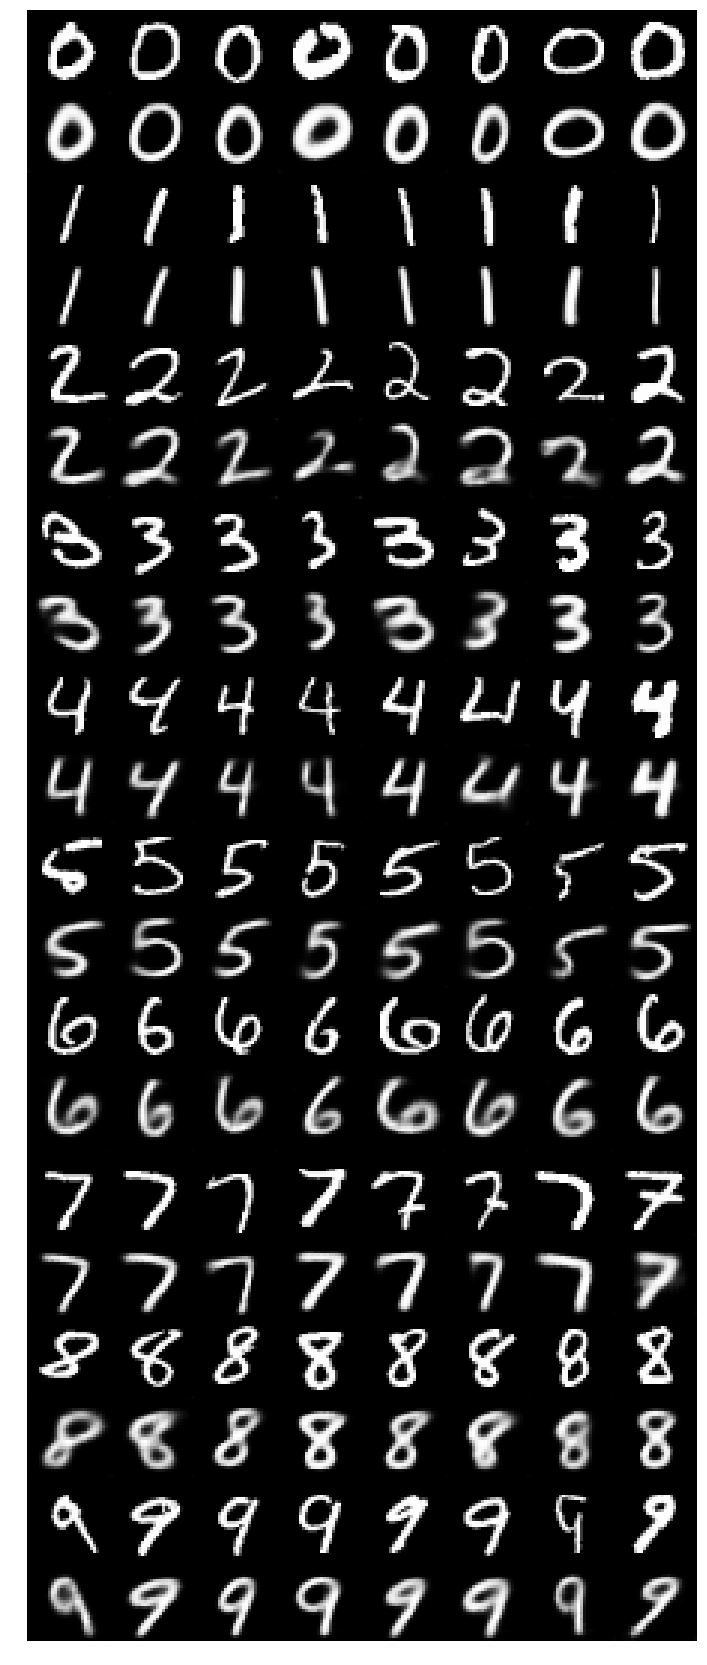

In [0]:
images = []
for (data_loader, model) in zip(test_loader_by_class, models_by_class):
  test_images, labels = iter(data_loader).next()
  test_images = test_images[:8, ...]
  test_batch = test_images.to(device)
  with th.no_grad():
    reconst_images, _, _ = model(test_batch)
  reconst_images = reconst_images.view(-1, 1, 28, 28)
  images.extend([test_images, reconst_images])
images = np.stack(images)
visualize_images(images)

### Sampling z ~ N(0, 1)

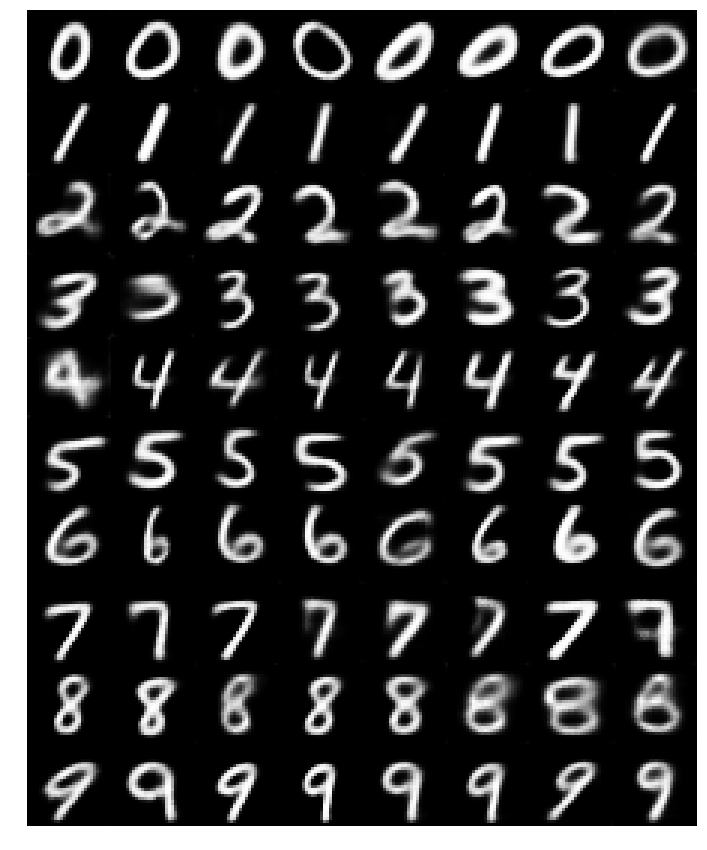

In [0]:
images = []
for i, model in enumerate(models_by_class):
  images.append(sample_images(model, num_samples=batch_size)[:8])
images = np.stack(images)  
visualize_images(images)

### Reconstructing other classes

In [0]:
images_cm = [
    iter(data_loader).next()[0][:1, ...] for data_loader in test_loader_by_class
]
images_cm = th.cat(images_cm).to(device)

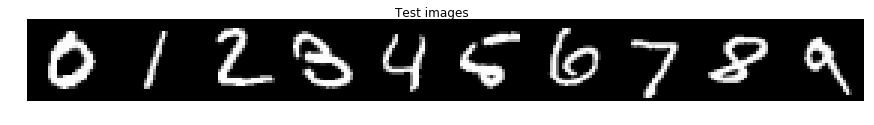

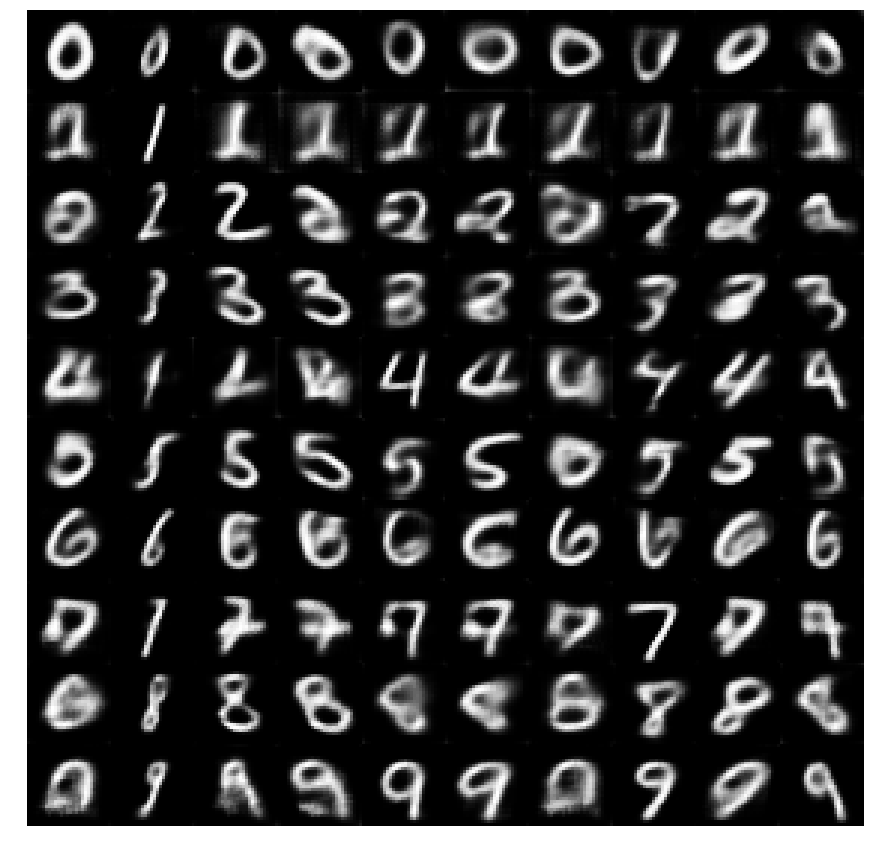

In [0]:
visualize_images(images_cm.cpu().numpy(), title=f'Test images')

confusion_grid = []
for model in models_by_class:
  with th.no_grad():
    reconst_images, _, _ = model(images_cm)
  reconst_images = reconst_images.view(-1, 1, 28, 28).cpu().numpy()

  confusion_grid.append(reconst_images)
confusion_grid = np.stack(confusion_grid)
visualize_images(confusion_grid)

### Classification

In [0]:
class VaeClassifier:
  def __init__(self, models_by_class):
    self._models_by_class = models_by_class
    
  def __call__(self, x):
    x_reconsts = [model.encode_decode(x)[0] for model in self._models_by_class]
    log_probs = [self.log_prob(x, x_i) for x_i in x_reconsts]
    #print(log_probs)
    log_probs = th.stack(log_probs).t()
    #print(log_probs)
    return log_probs
  
  def log_prob(self, x, x_reconst):
    reconst_loss = thf.binary_cross_entropy(x_reconst, x, reduction='none')
    reconst_loss = th.sum(reconst_loss, dim=(-3, -2, -1))
    #kl_div = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #loss = reconst_loss + kl_div
    return -reconst_loss

classifier = VaeClassifier(models_by_class)  

errors = []
with th.no_grad():
  correct, total = 0, 0
  for idx, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = classifier(images)
    _, predicted = th.max(outputs.data, 1)
    total += labels.size(0)
    correct_mask = (predicted == labels)
    correct += correct_mask.sum().item()
    
    error_idxs = idx * batch_size + np.where(~correct_mask)[0]
    error_labels = labels[~correct_mask]
    error_preds = predicted[~correct_mask]
    error_batch = np.stack([error_idxs, error_labels, error_preds]).transpose()
    errors.append(error_batch)
  errors = np.concatenate(errors)
    
  accuracy = correct / total
  print(f'Accuracy of model on 10000 test images: {100 * accuracy:0.2f}%')

Accuracy of model on 10000 test images: 97.03%


###  Error analysis

In [0]:
errors[:5]

array([[ 41,   7,   2],
       [ 61,   8,   3],
       [ 73,   9,   7],
       [ 92,   9,   4],
       [151,   9,   8]])

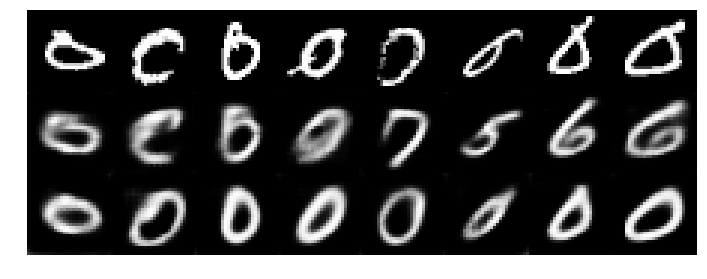

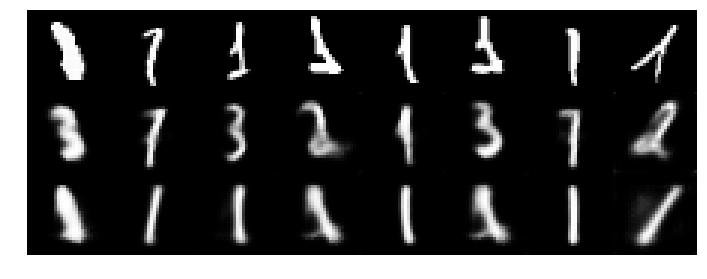

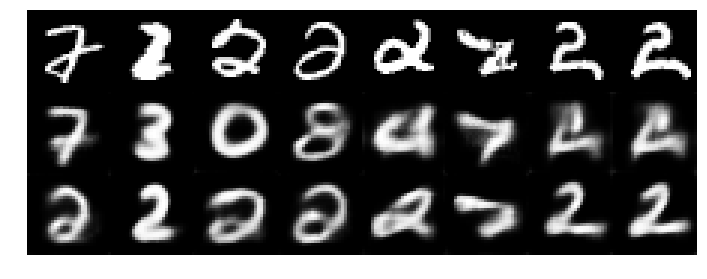

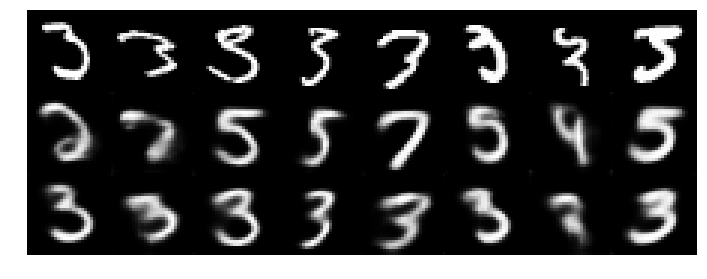

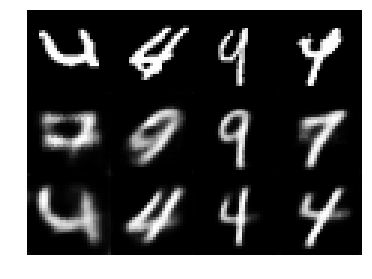

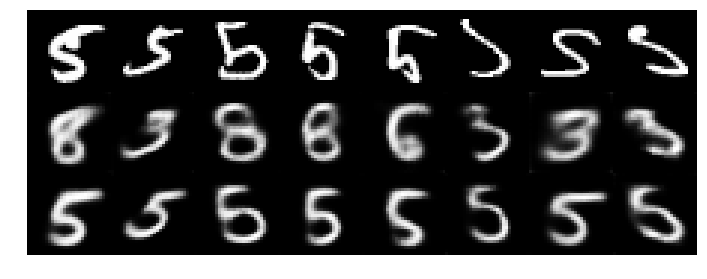

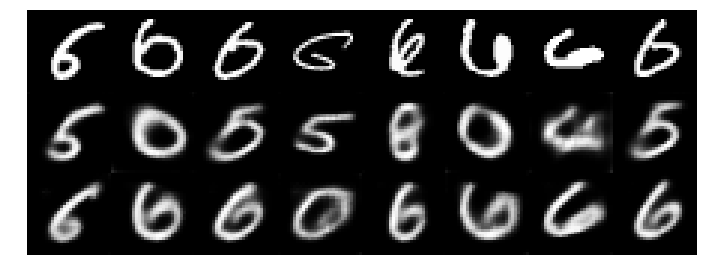

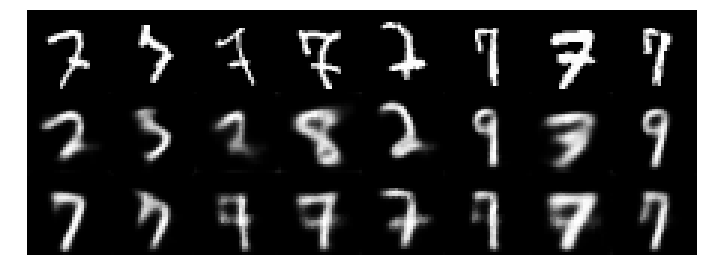

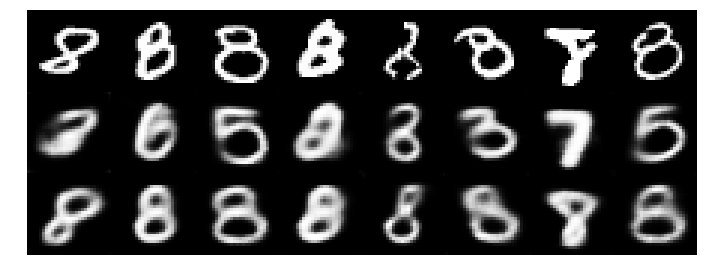

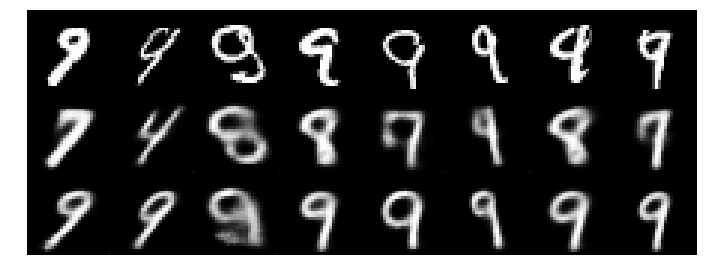

In [0]:
num_samples = 8
for label_class in range(10):
  class_errors = errors[np.where(errors[:, 1] == label_class)][:num_samples]
  error_samples = []
  for i in range(min(num_samples, class_errors.shape[0])):
    idx, _, pred = class_errors[i]
    image = test_ds[idx][0].unsqueeze(0)
    correct_model = models_by_class[label_class]
    incorrect_model = models_by_class[pred]
    with th.no_grad():
      image_th = image.to(device)
      correct_reconst = correct_model.encode_decode(image_th)[0]
      incorrect_reconst = incorrect_model.encode_decode(image_th)[0]
    error_sample = np.stack([image, incorrect_reconst, correct_reconst], axis=0)
    error_samples.append(error_sample)
  error_samples = np.concatenate(error_samples, axis=1)
  visualize_images(error_samples)

# Errors by class. top: original. mid: mistaken class. bot: correct class

## Future Work

Things to try


*   Verify that BCE gives reconstruction log_prob
*   Adjust log_prob by mean on the train set, for that class. Some classes seem harder than others to model
*   Improve encoder-decoders. Reconstructions in-class aren't very good yet
*   Play with latent size
*   Play with other prob density estimates (e.g. account for latent likelihood)


---

Longer term things to try


*   Train 1 model on all classes instead of 1 per class. Provide class as input. This models p(x, y) instead of p(x).





## Save model

In [0]:
th.save(model.state_dict(), '/tmp/vae.ckpt')